
# LLM-CRYPTO-BENCH – Results Analysis
# We compute:
# - Strict accuracy (exact match)
# - Levenshtein similarity (string/charcter-level)
# - Semantic similarity (sentence embeddings)
# for cipherbank, cipherbench (decryption) and cybermetric (multiple choice).


# Cell 1 – Imports

In [13]:
from pathlib import Path
import json
import re
from typing import Dict, Any, List

import numpy as np
import pandas as pd

from rapidfuzz.distance import Levenshtein
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt


# Cell 2 – Paths and JSONL loader

In [14]:
BASE_DIR = Path.cwd()  # run this notebook from project root
DATASETS_DIR = BASE_DIR / "datasets"
RESULTS_DIR = BASE_DIR / "results"


def load_jsonl(path: Path) -> List[Dict[str, Any]]:
    records = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            records.append(json.loads(line))
    return records


def load_dataset_plaintext_maps() -> Dict[str, Dict[str, Dict[str, Any]]]:
    """
    Build mapping from (dataset, id) -> gold plaintext and algorithm
    for cipherbank and cipherbench.
    """
    dataset_maps: Dict[str, Dict[str, Dict[str, Any]]] = {}

    for dataset_name in ["cipherbank", "cipherbench"]:
        path = DATASETS_DIR / dataset_name / f"{dataset_name}.jsonl"
        records = load_jsonl(path)

        id_map: Dict[str, Dict[str, Any]] = {}
        for rec in records:
            rec_id = rec["id"]
            id_map[rec_id] = {
                "dataset": rec.get("dataset", dataset_name),
                "algorithm": rec.get("algorithm"),
                "plaintext": rec["plaintext"],
            }
        dataset_maps[dataset_name] = id_map

    return dataset_maps


dataset_maps = load_dataset_plaintext_maps()


# Cell 3 – Answer parsing + normalization helpers

In [15]:
ANSWER_PREFIX_RE = re.compile(r"answer:\s*", re.IGNORECASE)
MC_ANSWER_RE = re.compile(r"answer:\s*([A-D])\b", re.IGNORECASE)
WS_RE = re.compile(r"\s+")


def extract_answer_text(output: str) -> str:
    """
    For decryption tasks:
      'ANSWER: I had a beta fish.' -> 'I had a beta fish.'
    """
    if output is None:
        return ""
    text = output.strip()
    match = ANSWER_PREFIX_RE.search(text)
    if match:
        text = text[match.end():]
    return text.strip()


def extract_mc_answer_letter(output: str) -> str:
    """
    For cybermetric multiple choice:
      'ANSWER: C' -> 'C'
    (We don't actually need this for metrics since we use the 'correct' flag,
     but it's here for completeness.)
    """
    if output is None:
        return ""
    match = MC_ANSWER_RE.search(output)
    if not match:
        return ""
    return match.group(1).upper()


def normalize_text_for_exact(text: str) -> str:
    """
    Minimal normalization for strict accuracy.
    Exact string match: case-sensitive, punctuation-sensitive.
    """
    if text is None:
        return ""
    return text.strip()


def normalize_text_for_similarity(text: str) -> str:
    """
    Normalization for Levenshtein + embeddings:
    - lowercase
    - strip surrounding quotes
    - collapse whitespace
    """
    if text is None:
        return ""
    t = text.strip()

    # remove matching surrounding quotes
    if len(t) >= 2 and (
        (t[0] == '"' and t[-1] == '"') or
        (t[0] == "'" and t[-1] == "'")
    ):
        t = t[1:-1].strip()

    t = t.lower()
    t = WS_RE.sub(" ", t)
    return t


# Cell 4 – Load all model results

In [16]:
def load_all_results() -> pd.DataFrame:
    """
    Load all JSONL files under results/ into a single DataFrame.

    Expected filenames:
      cipherbank__gemini-2.5-flash-lite.jsonl
      cipherbench__gpt-oss-20b.jsonl
      cybermetric__llama-3.3-70b-instruct.jsonl
    """
    all_rows: List[Dict[str, Any]] = []

    for path in sorted(RESULTS_DIR.glob("*.jsonl")):
        name = path.name
        if "__" not in name:
            # Skip unexpected filenames
            continue

        dataset_name, model_name_with_ext = name.split("__", 1)
        model_name = model_name_with_ext.rsplit(".jsonl", 1)[0]

        records = load_jsonl(path)
        for rec in records:
            row = dict(rec)  # shallow copy
            # we rely on 'dataset' and 'model' being present in rec
            # dataset_name and model_name from filename are backups if needed
            if "dataset" not in row:
                row["dataset"] = dataset_name
            if "model" not in row:
                row["model"] = model_name
            all_rows.append(row)

    df = pd.DataFrame(all_rows)
    return df


df_results_raw = load_all_results()


# Cell 5 – Build cipher dataframe (cipherbank + cipherbench)

In [17]:
def build_cipher_dfs(
    df_results: pd.DataFrame,
    dataset_maps: Dict[str, Dict[str, Dict[str, Any]]],
) -> pd.DataFrame:
    """
    Return a DataFrame with:
      dataset, model, id, algorithm_final, ciphertext, gold_plaintext, pred_plaintext, ...
    for cipherbank and cipherbench only.
    """
    mask_cipher = df_results["dataset"].isin(["cipherbank", "cipherbench"])
    df = df_results.loc[mask_cipher].copy()

    # model outputs (predicted plaintext)
    df["pred_plaintext_raw"] = df["output"].apply(extract_answer_text)

    gold_dataset = []
    gold_algorithm = []
    gold_plaintext = []

    for _, row in df.iterrows():
        ds = row["dataset"]
        rec_id = row["id"]
        mapping = dataset_maps.get(ds, {}).get(rec_id)
        if mapping is None:
            gold_dataset.append(ds)
            gold_algorithm.append(row.get("algorithm"))
            gold_plaintext.append(None)
        else:
            gold_dataset.append(mapping["dataset"])
            gold_algorithm.append(mapping["algorithm"])
            gold_plaintext.append(mapping["plaintext"])

    df["gold_dataset"] = gold_dataset
    df["gold_algorithm"] = gold_algorithm
    df["gold_plaintext_raw"] = gold_plaintext

    # prefer explicit algorithm, else infer from id
    algo_from_id = df["id"].str.split("/", expand=True).iloc[:, 1]
    df["algorithm_final"] = df["algorithm"].fillna(algo_from_id)

    # normalizations
    df["pred_plaintext_exact"] = df["pred_plaintext_raw"].apply(normalize_text_for_exact)
    df["gold_plaintext_exact"] = df["gold_plaintext_raw"].apply(normalize_text_for_exact)

    df["pred_plaintext_sim"] = df["pred_plaintext_raw"].apply(normalize_text_for_similarity)
    df["gold_plaintext_sim"] = df["gold_plaintext_raw"].apply(normalize_text_for_similarity)

    # Only keep rows where we have a gold plaintext
    df = df[df["gold_plaintext_raw"].notna()].reset_index(drop=True)
    return df


df_cipher = build_cipher_dfs(df_results_raw, dataset_maps)


# Cell 6 – Strict accuracy + Levenshtein similarity

### Strict Accuracy and Levenshtein Similarity

This function computes two core metrics for evaluating LLM decryption:

**1. Strict Accuracy (Exact Match)**
- Checks whether the predicted plaintext matches the gold plaintext exactly  
- Implemented using simple string equality  
- Gives a score of **1 for perfect match**, **0 otherwise**

**2. Levenshtein Similarity (String-Level Closeness)**
- Measures how many single-character edits are needed to turn the prediction into the gold plaintext  
- Fewer edits → higher similarity  
- Normalized to a **0–1** score so models can get partial credit even if not perfect

Together, these metrics show:
- Whether a model decrypts correctly (strict accuracy)
- How close the model gets when it makes small mistakes (Levenshtein similarity)


In [18]:
def compute_string_metrics_levenshtein(df: pd.DataFrame) -> pd.DataFrame:
    """
    Expects columns:
      pred_plaintext_exact, gold_plaintext_exact,
      pred_plaintext_sim, gold_plaintext_sim

    Adds:
      strict_correct (0/1)
      levenshtein_sim (0-1)
    """
    df = df.copy()

    # strict exact match
    df["strict_correct"] = (
        df["pred_plaintext_exact"] == df["gold_plaintext_exact"]
    ).astype(int)

    # normalized Levenshtein similarity in [0, 1]
    lev_sims = []
    for pred, gold in zip(df["pred_plaintext_sim"], df["gold_plaintext_sim"]):
        if not pred and not gold:
            lev_sims.append(np.nan)
            continue
        max_len = max(len(pred), len(gold))
        if max_len == 0:
            lev_sims.append(np.nan)
            continue
        dist = Levenshtein.distance(pred, gold)
        sim = 1.0 - (dist / max_len)
        lev_sims.append(sim)

    df["levenshtein_sim"] = lev_sims
    return df


df_cipher_metrics = compute_string_metrics_levenshtein(df_cipher)


# Cell 7 – Semantic similarity (embedding-based cosine)

### Semantic Similarity (Meaning-Level Evaluation)

This function measures how similar the *meaning* of the model’s predicted plaintext is to the gold plaintext.

We use a sentence-transformer model (**MiniLM**) to compute **embeddings**, which are numerical vector representations of sentences. These embeddings capture semantic meaning rather than exact wording.

The process:

1. **Embed each unique plaintext** (gold and predicted) using MiniLM  
2. **Normalize the embeddings** (adjust embedding vector so it has a length of 1)  
3. Compute **cosine similarity** between gold and predicted vectors  
   - Higher score → similar meaning  
   - Lower score → different meaning  

This metric is useful because LLMs often output paraphrased or slightly reworded text. Strict accuracy and Levenshtein measure exactness, but **semantic similarity rewards correct meaning**, even if the wording is different.

Final output column:  
- `semantic_sim` (roughly 0–1 range)


In [19]:
# Load sentence embedding model
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


def compute_semantic_similarity(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute semantic similarity using sentence embeddings (MiniLM) and cosine similarity.
    Adds:
      semantic_sim (roughly 0-1 in this setting)
    """
    df = df.copy()

    # Collect unique strings to embed once
    texts = pd.unique(
        pd.concat(
            [df["gold_plaintext_sim"], df["pred_plaintext_sim"]],
            ignore_index=True,
        )
    )
    texts = [t for t in texts if isinstance(t, str) and t != ""]

    # Compute embeddings as torch tensors
    embeddings = embedding_model.encode(
        texts,
        batch_size=64,
        show_progress_bar=False,
        convert_to_numpy=False,
    )

    # Map: text -> normalized torch vector
    emb_map: Dict[str, torch.Tensor] = {}
    for t, emb in zip(texts, embeddings):
        if not isinstance(emb, torch.Tensor):
            emb = torch.tensor(emb)
        norm = emb.norm(p=2)
        if norm == 0:
            emb_norm = emb
        else:
            emb_norm = emb / norm
        emb_map[t] = emb_norm

    def get_vec(text: str):
        if not isinstance(text, str) or text == "":
            return None
        return emb_map.get(text)

    sem_sims = []
    for gold, pred in zip(df["gold_plaintext_sim"], df["pred_plaintext_sim"]):
        v_g = get_vec(gold)
        v_p = get_vec(pred)
        if v_g is None or v_p is None:
            sem_sims.append(np.nan)
            continue
        # cosine similarity of normalized vectors = dot product
        sim = torch.dot(v_g, v_p).item()
        sem_sims.append(float(sim))

    df["semantic_sim"] = sem_sims
    return df


df_cipher_metrics = compute_semantic_similarity(df_cipher_metrics)


# Cell 8 – Aggregations (cipher + cybermetric + combined summary)

In [20]:
# Cipher (decryption) metrics aggregated by dataset & model
agg_model_dataset = (
    df_cipher_metrics
    .groupby(["dataset", "model"], as_index=False)
    .agg(
        n=("id", "count"),
        strict_acc=("strict_correct", "mean"),
        lev_sim_mean=("levenshtein_sim", "mean"),
        sem_sim_mean=("semantic_sim", "mean"),
    )
    .sort_values(["dataset", "model"])
)

# Cybermetric (multiple choice) metrics
def build_cybermetric_df(df_results: pd.DataFrame) -> pd.DataFrame:
    """
    Build DataFrame for cybermetric:
    Uses existing 'correct' flag (1/0) as strict accuracy.
    """
    df = df_results[df_results["dataset"] == "cybermetric"].copy()
    df["strict_correct"] = df["correct"].astype(int)
    return df


df_cyber = build_cybermetric_df(df_results_raw)

agg_cyber_model = (
    df_cyber
    .groupby(["dataset", "model"], as_index=False)
    .agg(
        n=("id", "count"),
        strict_acc=("strict_correct", "mean"),
    )
    .sort_values(["dataset", "model"])
)

# Align columns and combine cipher + cybermetric
agg_cipher = agg_model_dataset.copy()
agg_cipher["metric_type"] = "decryption"

agg_cyber_summary = agg_cyber_model.copy()
agg_cyber_summary["lev_sim_mean"] = np.nan
agg_cyber_summary["sem_sim_mean"] = np.nan
agg_cyber_summary["metric_type"] = "multiple_choice"

common_cols = [
    "dataset",
    "model",
    "n",
    "strict_acc",
    "lev_sim_mean",
    "sem_sim_mean",
    "metric_type",
]

agg_cipher_aligned = agg_cipher[common_cols]
agg_cyber_aligned = agg_cyber_summary[common_cols]

combined_summary = pd.concat(
    [agg_cipher_aligned, agg_cyber_aligned],
    ignore_index=True,
    sort=False,
)

combined_summary = combined_summary.sort_values(["dataset", "model", "metric_type"])


# Cell 9 - Figure 1: Strict Accuracy by Model and Dataset chart
# Bar chart of strict accuracy for:
# - cipherbank
# - cipherbench
# - cybermetric


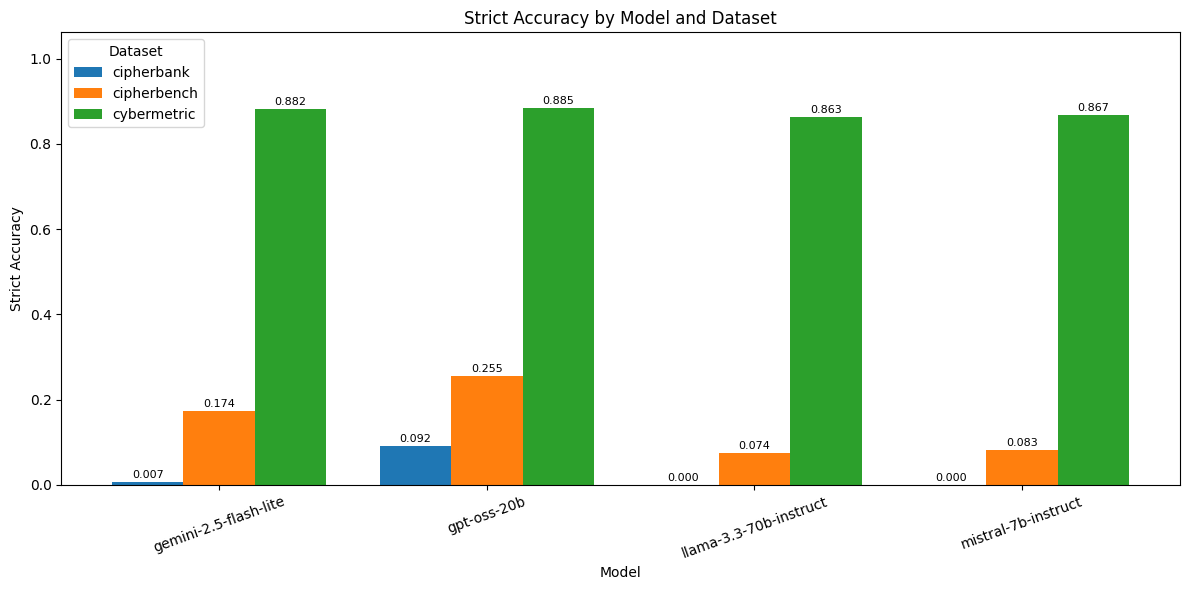

In [21]:
df_strict = combined_summary.copy()

models = sorted(df_strict["model"].unique())
datasets = sorted(df_strict["dataset"].unique())

x = np.arange(len(models))
bar_width = 0.8 / len(datasets)

plt.figure(figsize=(12, 6))

for i, ds in enumerate(datasets):
    sub = df_strict[df_strict["dataset"] == ds]

    # Strict accuracy values aligned to model ordering
    y = [sub.loc[sub["model"] == m, "strict_acc"].values[0] for m in models]

    # Draw bars
    bars = plt.bar(x + i * bar_width, y, width=bar_width, label=ds)

    # Add labels above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.005,
            f"{height:.3f}",
            ha="center", va="bottom", fontsize=8,
        )

plt.xticks(x + bar_width * (len(datasets) - 1) / 2, models, rotation=20)
plt.ylabel("Strict Accuracy")
plt.xlabel("Model")
plt.title("Strict Accuracy by Model and Dataset")
plt.ylim(0, df_strict["strict_acc"].max() * 1.20)
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


# Cell 10 – Heatmap helper + metric matrix builder

In [22]:
def plot_annotated_heatmap(mat, row_labels, col_labels, title, fmt=".3f"):
    plt.figure(figsize=(max(8, len(col_labels) * 0.7), max(4, len(row_labels) * 0.5)))
    im = plt.imshow(mat, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    # Tick labels
    plt.xticks(np.arange(len(col_labels)), col_labels, rotation=45, ha="right")
    plt.yticks(np.arange(len(row_labels)), row_labels)

    # Add values inside cells
    n_rows, n_cols = mat.shape
    for i in range(n_rows):
        for j in range(n_cols):
            value = mat[i, j]
            if np.isnan(value):
                text_str = ""
            else:
                text_str = format(value, fmt)
            plt.text(
                j, i, text_str,
                ha="center", va="center",
                color="black", fontsize=9,
            )

    plt.xlabel("Algorithm")
    plt.ylabel("Model")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def build_metric_matrix(df: pd.DataFrame, dataset: str, metric_col: str):
    """
    Build a matrix of mean(metric_col) for (model, algorithm_final)
    for a given dataset.
    Returns:
      mat (n_models x n_algorithms),
      model_labels,
      algorithm_labels
    """
    sub = df[df["dataset"] == dataset].copy()

    models = sorted(sub["model"].unique())
    algos = sorted(sub["algorithm_final"].unique())

    mat = np.full((len(models), len(algos)), np.nan)

    for i, m in enumerate(models):
        for j, a in enumerate(algos):
            vals = sub.loc[
                (sub["model"] == m) & (sub["algorithm_final"] == a),
                metric_col,
            ]
            if not vals.empty:
                mat[i, j] = vals.mean()

    return mat, models, algos



# Figures 2–5 – Similarity Heatmaps by Algorithm
# We plot:
# - Levenshtein similarity by (model, algorithm) for cipherbank and cipherbench
# - Semantic similarity by (model, algorithm) for cipherbank and cipherbench


# Cell 11 – Figures 2 & 3: Levenshtein similarity heatmaps

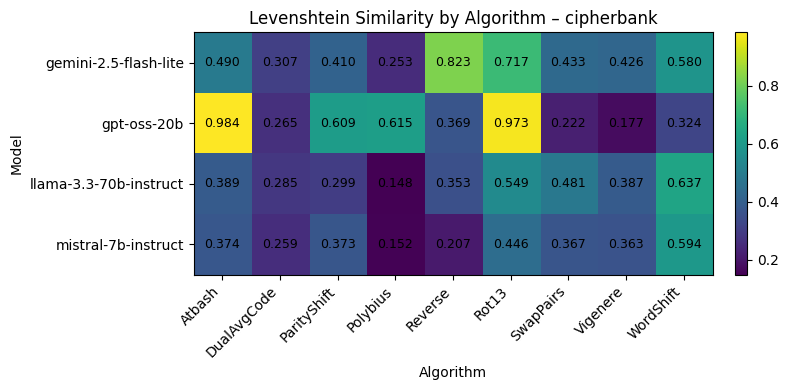

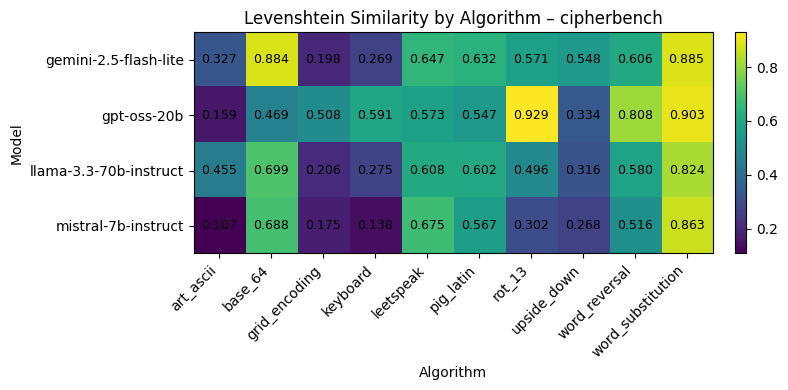

In [ ]:
datasets_to_plot = ["cipherbank", "cipherbench"]

for ds in datasets_to_plot:
    mat, models_h, algos_h = build_metric_matrix(
        df_cipher_metrics, ds, metric_col="levenshtein_sim"
    )
    plot_annotated_heatmap(
        mat,
        row_labels=models_h,
        col_labels=algos_h,
        title=f"Levenshtein Similarity by Algorithm - {ds}",
        fmt=".3f",
    )


### Levenshtein Similarity – Model Summary (CipherBank)
1. gemini-2.5-flash-lite

    - Average similarity: 0.493

    - Best algorithm: Reverse (0.823)

    - Worst algorithm: Polybius (0.253)

2. gpt-oss-20b

    - Average similarity: 0.504

    - Best algorithm: Atbash (0.984)

    - Worst algorithm: Vigenere (0.177)

3. llama-3.3-70b-instruct

    - Average similarity: 0.392

    - Best algorithm: WordShift (0.637)

    - Worst algorithm: Polybius (0.148)

4. mistral-7b-instruct

    - Average similarity: 0.348

    - Best algorithm: WordShift (0.594)

    - Worst algorithm: Polybius (0.152)

### Levenshtein Similarity – Model Summary (CipherBench)
1. gemini-2.5-flash-lite

    - Average similarity: 0.557

    - Best algorithm: word_substitution (0.885)

    - Worst algorithm: grid_encoding (0.198)

2. gpt-oss-20b

    - Average similarity: 0.582

    - Best algorithm: rot_13 (0.929)

    - Worst algorithm: art_ascii (0.159)

3. llama-3.3-70b-instruct

    - Average similarity: 0.506

    - Best algorithm: word_substitution (0.824)

    - Worst algorithm: grid_encoding (0.206)

4. mistral-7b-instruct

    - Average similarity: 0.430

    - Best algorithm: word_substitution (0.863)

    - Worst algorithm: art_ascii (0.107)


# Cell 12 – Figures 4 & 5: Semantic similarity heatmaps

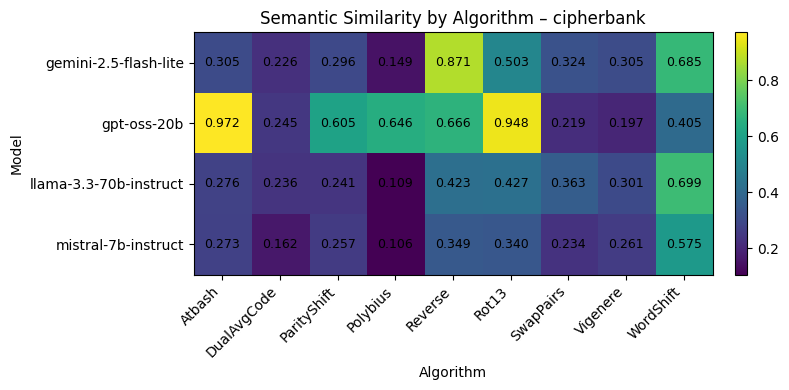

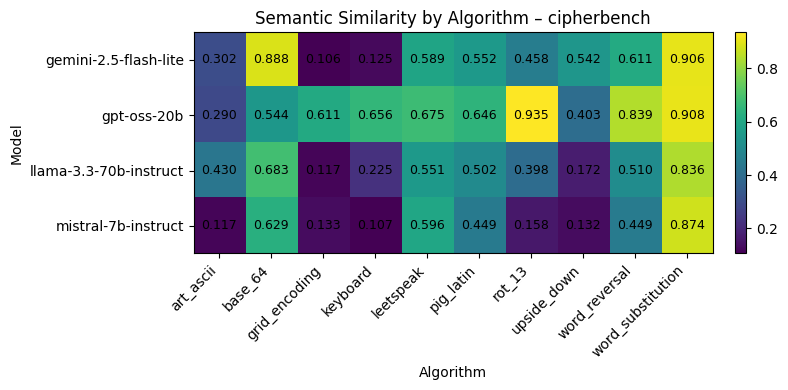

In [ ]:
for ds in datasets_to_plot:
    mat, models_h, algos_h = build_metric_matrix(
        df_cipher_metrics, ds, metric_col="semantic_sim"
    )
    plot_annotated_heatmap(
        mat,
        row_labels=models_h,
        col_labels=algos_h,
        title=f"Semantic Similarity by Algorithm - {ds}",
        fmt=".3f",
    )


### Semantic Similarity – Model Summary (CipherBank)
1. gemini-2.5-flash-lite

    - Average similarity: 0.407

    - Best algorithm: Reverse (0.871)

    - Worst algorithm: Polybius (0.149)

2. gpt-oss-20b

    - Average similarity: 0.545

    - Best algorithm: Atbash (0.972)

    - Worst algorithm: Vigenere (0.197)

3. llama-3.3-70b-instruct

    - Average similarity: 0.342

    - Best algorithm: WordShift (0.699)

    - Worst algorithm: Polybius (0.109)

4. mistral-7b-instruct

    - Average similarity: 0.284

    - Best algorithm: WordShift (0.575)

    - Worst algorithm: Polybius (0.106)


### Semantic Similarity – Model Summary (CipherBench)
1. gemini-2.5-flash-lite

    - Average similarity: 0.508

    - Best algorithm: word_substitution (0.906)

    - Worst algorithm: grid_encoding (0.106)

2. gpt-oss-20b

    - Average similarity: 0.651

    - Best algorithm: rot_13 (0.935)

    - Worst algorithm: art_ascii (0.290)

3. llama-3.3-70b-instruct

    - Average similarity: 0.442

    - Best algorithm: word_substitution (0.836)

    - Worst algorithm: grid_encoding (0.117)

4. mistral-7b-instruct

    - Average similarity: 0.364

    - Best algorithm: word_substitution (0.874)

    - Worst algorithm: art_ascii (0.107)


### Overall Conclusion

- **1. GPT-OSS-20B is the strongest model overall.**
- **2. Gemini-2.5-Flash-Lite is 2nd.**
- **3. Llama-3.3-70b-Instruct performs moderately**

- **4. Mistral-7b-Instruct consistently ranks lowest**


- **Overall trend:** LLMs are *not reliable decryptors*, but they show clear capability gradients.
  - Stronger models maintain better lexical and semantic alignment.
  - Weaker models struggle to preserve structure or meaning across the different ciphers.

- **Combined metrics (strict, Levenshtein, semantic)** provide a complete picture:
  - They reveal not only whether a model succeeds, but *how close it gets* and *where it fails*.
